In [ ]:
!pip install torch torchvision

In [2]:
from google.colab import drive
import cv2
import torch
import torchvision
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import pandas as pd
import os
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
trainSet_path = "/content/drive/MyDrive/Colab Notebooks/train_data"
testSet_path = "/content/drive/MyDrive/Colab Notebooks/test_data"

## Data pre-processing

For each video, we extract the RGB image every 6 frames and store into "frames", therefore for each video data we should have a total number of "video_total_frame//6" RGB images extracted, and the array stores them will have the shape: (ith_video_total_frame//6, 224, 224, 3).  
Note: This is basically identical to the functionality of "sample_video.py" provided by the dataset creator. In this implementation, we do not create extra ".png" files, instead of that, we directly store those RGB images into variables.

Secondly, load the set of ground truth segmentation mask into "y". For each video, it should have the number of "ceil(video_total_frame/60)" of grayscale images (segmentation masks).

In [7]:
# Get "X"
def extract_RGB_images(data_path):
  operations = os.listdir(data_path)
  x = []

  for video_name in operations:
    video_path = data_path + f"/{video_name}" + f"/video_left.avi"
    cap = cv2.VideoCapture(video_path)
    fps = cap.get(cv2.CAP_PROP_FPS)
    frame_interval = int(fps/10)

    frames = []
    frame_count = 0
    while True:
      ret, frame = cap.read()
      if not ret:
        break
      # Every 6 frames, record the frame into an RGB image
      if frame_count % frame_interval == 0:
        rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        rgb_frame = cv2.resize(rgb_frame, (224, 224))
        frames.append(rgb_frame)
      frame_count += 1

    cap.release()
    x.append(frames)
  return x

# Get 'y'
def load_GroundTruth_masks(data_path):
  operations = os.listdir(data_path)
  y = []

  for video_name in operations:
    ground_truth_path = data_path + f"/{video_name}" + f"/segmentation"
    ground_truth_masks = sorted(os.listdir(ground_truth_path))
    frames = []
    for mask in ground_truth_masks:
      ground_truth_sm = cv2.imread(ground_truth_path + "/" + mask)
      ground_truth_sm = cv2.cvtColor(ground_truth_sm, cv2.COLOR_RGB2GRAY)
      ground_truth_sm = cv2.resize(ground_truth_sm, (224, 224))
      frames.append(ground_truth_sm)
    y.append(frames)
  return y

In [8]:
train_x_set = extract_RGB_images(trainSet_path)
train_y_set = load_GroundTruth_masks(trainSet_path)

test_x_set = extract_RGB_images(testSet_path)
test_y_set = load_GroundTruth_masks(testSet_path)

Explore the RGB images extracted; plotting the initial and last frame of videos, and the first 60 frames (frame_6, frame_12, ..., frame_60).

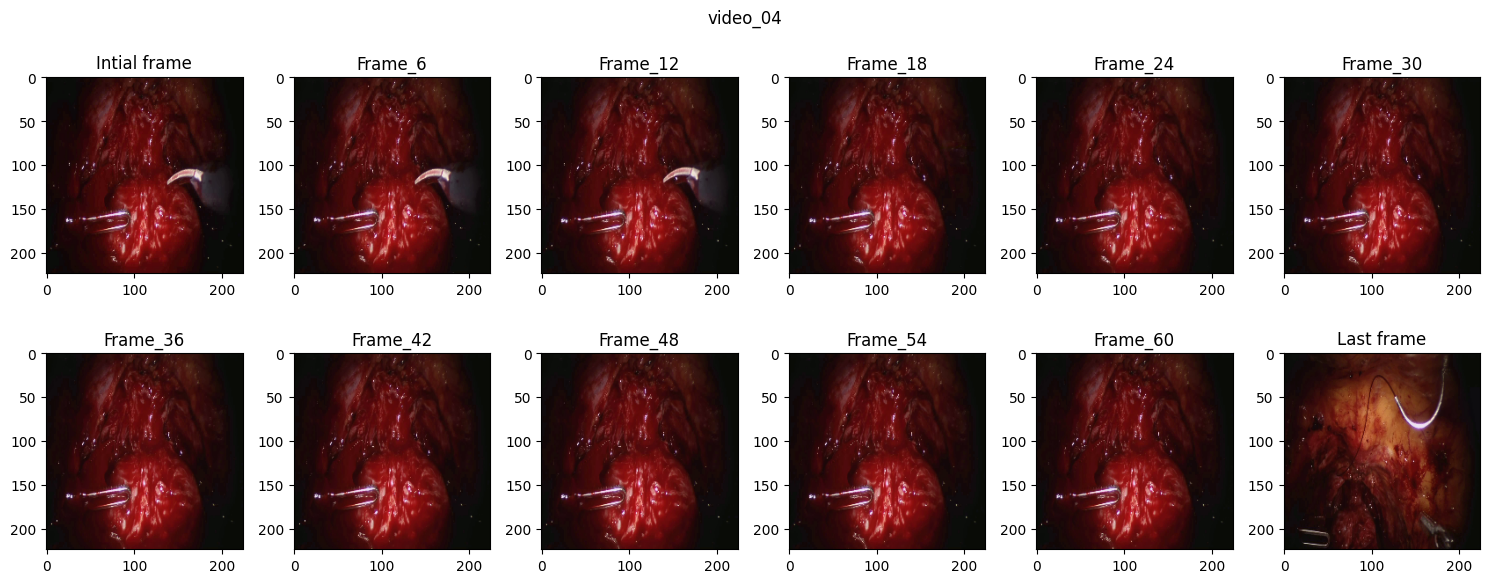

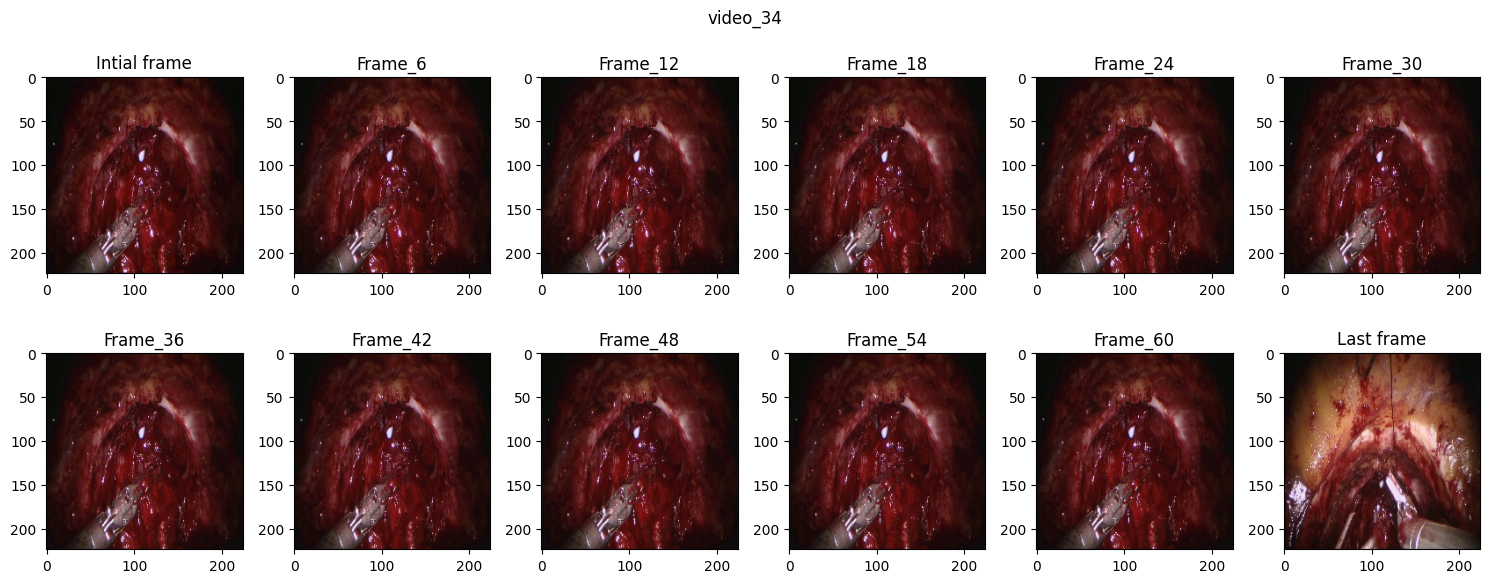

In [ ]:
operations = os.listdir(trainSet_path)
example_videos = [0, 2] # i.e., video_04, video_34

for example in example_videos:
  count = 1
  fig, ax = plt.subplots(nrows=2, ncols=6, figsize=(15, 6))

  ax[0,0].imshow(train_x_set[example][0])
  ax[0,0].set_title("Intial frame")
  for i in range(2):
    for j in range(6):
      if i == 0 and j == 0:
        continue
      if i == 1 and j == 5:
        continue
      ax[i,j].imshow(train_x_set[example][count])
      ax[i,j].set_title(f"Frame_{count*6}")
      count += 1
  ax[1,5].imshow(train_x_set[example][-1])
  ax[1,5].set_title("Last frame")

  fig.suptitle(f"{operations[example]}")
  plt.tight_layout()
  plt.show()

  print()

Check the number RGB images are extracted from each video, respectively.

In [ ]:
print("Number of videos(operations):", len(train_x_set))
for i in range(len(train_x_set)):
  print(f"{operations[i]} - Number of RGB images extracted (in 10 Hz):", len(train_x_set[i]))

Number of videos(operations): 3
video_04 - Number of RGB images extracted (in 10 Hz): 1302
video_08 - Number of RGB images extracted (in 10 Hz): 1480
video_34 - Number of RGB images extracted (in 10 Hz): 1008


Check the number of ground truth segmentation masks for each video. Note: This should be exactly the number of png files in the "video_xx/segmentation" folder.

In [ ]:
for i in range(len(train_y_set)):
  print(f"{operations[i]} - Number of ground truth segmentation masks (in 60 Hz):", len(train_y_set[i]))

video_04 - Number of ground truth segmentation masks (in 60 Hz): 131
video_08 - Number of ground truth segmentation masks (in 60 Hz): 148
video_34 - Number of ground truth segmentation masks (in 60 Hz): 101


Explore the ground truth segmentation masks

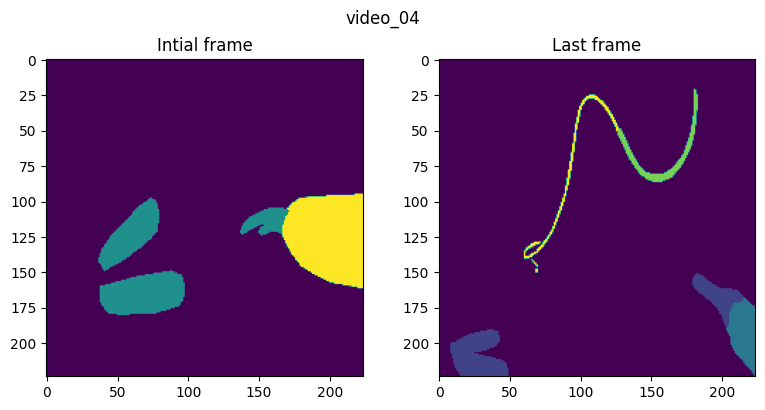

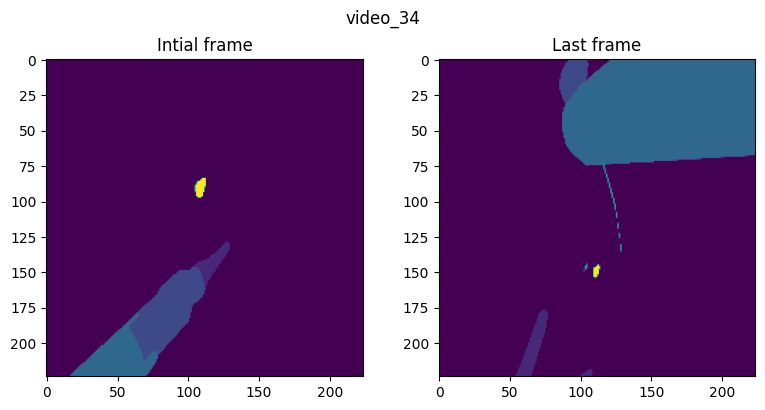

In [ ]:
for example in example_videos:
  fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(8, 4))

  ax[0].imshow(train_y_set[example][0])
  ax[0].set_title("Intial frame")
  ax[1].imshow(train_y_set[example][-1])
  ax[1].set_title("Last frame")

  fig.suptitle(f"{operations[example]}")
  plt.tight_layout()
  plt.show()

### Padding
A crucial step: To indicate how many RGB images should be associated with each ground truth segmentation masks. For example, (frame_00, frame_06, ..., frame_36) are associated with "segmentation_000000000".

In [9]:
def map_gtMasks_toRGBs(data_path):
  operations = os.listdir(data_path)
  all_mapping = []

  for video_name in operations:
    video_path = data_path + f"/{video_name}" + f"/video_left.avi"
    cap = cv2.VideoCapture(video_path)
    frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    cap.release()
    print(f"{video_name} - Total number of frames (in 1 Hz):", frame_count)

    rgb_img_indices = [i for i in range(0, frame_count, 6)]
    ground_truth_sm_indices = [i for i in range(0, frame_count, 60)]

    mapping = {}
    for rgb_img_index in rgb_img_indices:
      ground_truth_sm_index = min(ground_truth_sm_indices, key=lambda x: abs(x - rgb_img_index))
      mapping[rgb_img_index] = ground_truth_sm_index

    ground_truth_sm = np.zeros(len(ground_truth_sm_indices))
    for _, seg in list(mapping.items()):
      i = seg // 60
      ground_truth_sm[i] += 1

    all_mapping.append(ground_truth_sm)

  return all_mapping

In [10]:
print("Training set")
train_GroundTruth_mapping = map_gtMasks_toRGBs(trainSet_path)
print("Test set")
test_GroundTruth_mapping = map_gtMasks_toRGBs(testSet_path)

Training set
video_04 - Total number of frames (in 1 Hz): 7812
video_08 - Total number of frames (in 1 Hz): 8878
video_34 - Total number of frames (in 1 Hz): 6047
Test set
video_45 - Total number of frames (in 1 Hz): 6972


The purpose of this step is to decide how many copies are needed for each ground truth segmentation mask. For instance, the first operation(Video_04), we need to duplicate the first segmentation mask (i.e., 000000000.png) six times and the last segmentation mask (i.e., 000007800.png) six times, then ten times for all remaining segmentation masks.

In [ ]:
train_GroundTruth_mapping[0]

array([ 6., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10.,
       10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10.,
       10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10.,
       10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10.,
       10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10.,
       10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10.,
       10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10.,
       10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10.,
       10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10.,
       10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10.,
        6.])

Padding the "y" set, for each video, the number of ground truth segmentation mask should match the number of RGB images extracted. For instance, the video_04, 1302 RGB images extracted and 131 segmentation masks given, therefore we need to pad 131 -> 1302.

In [11]:
def padding_GroundTruth_masks(mapping, original_y):
  padded_y = []
  for i in range(len(mapping)):
    rgb_img_for_first_sm = int(mapping[i][0])
    rgb_img_for_last_sm = int(mapping[i][-1])
    duplicated_sm = [original_y[i][0]]*rgb_img_for_first_sm + original_y[i][1:-1]*10 + [original_y[i][-1]]*rgb_img_for_last_sm
    padded_y.append(duplicated_sm)
  return padded_y

In [12]:
train_padded_y_set = padding_GroundTruth_masks(train_GroundTruth_mapping, train_y_set)
test_padded_y_set = padding_GroundTruth_masks(test_GroundTruth_mapping, test_y_set)

In [ ]:
print("After padding, the number of ground truth segmentation masks for each video:")
print([len(video_i) for video_i in train_padded_y_set])

After padding, the number of ground truth segmentation masks for each video:
[1302, 1480, 1008]


Concatenate all RGB images (3 videos) for building the sample set, and all ground truth segmentation masks for building the label set.

In [13]:
x_train = torch.cat([torch.tensor(np.array(video)).permute(0,3,1,2) for video in train_x_set], dim=0)
y_train = torch.cat([torch.tensor(np.array(seg_mask)).unsqueeze(1) for seg_mask in train_padded_y_set], dim=0)

x_test = torch.cat([torch.tensor(np.array(video)).permute(0,3,1,2) for video in test_x_set], dim=0)
y_test = torch.cat([torch.tensor(np.array(seg_mask)).unsqueeze(1) for seg_mask in test_padded_y_set], dim=0)

Verify the length of img_set and label_set

In [14]:
print("Training set")
print("Total number of RGB images: ", x_train.shape)
print("Total number of segmentation masks: ", y_train.shape)
print("Test set")
print("Total number of RGB images: ", x_test.shape)
print("Total number of segmentation masks: ", y_test.shape)

Training set
Total number of RGB images:  torch.Size([3790, 3, 224, 224])
Total number of segmentation masks:  torch.Size([3790, 1, 224, 224, 3])
Test set
Total number of RGB images:  torch.Size([1162, 3, 224, 224])
Total number of segmentation masks:  torch.Size([1162, 1, 224, 224, 3])


A bit weird? According to the dataset description, there are 9 classes. If there are 10 unique class IDs, then we need to set classes_num as 10 when initialise the model. Note: class:0 is for the background.

In [ ]:
# Each pixel is associated with a class ID
y_train.unique()

tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=torch.uint8)

In [ ]:
y_test.unique()

tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=torch.uint8)

## Create datasets & loader

In this case (task: Semantic Segmentation), since we do not really care about the temporal relatonship between frames, therefore we can shuffle the dataset and that won't influence the validity of the dataset.

In [ ]:
class MyDataset(Dataset):
  def __init__(self, data_x, data_y):
      self.data_x = data_x
      self.data_y = data_y

  def __len__(self):
      return len(self.data_x)

  def __getitem__(self, idx):
      img = (self.data_x[idx]).float() / 255.0  # Normalise RGB values
      label = self.data_y[idx]                  # Keep pixels value as class ID
      return img, label

train_dataset = MyDataset(x_train, y_train)
test_dataset = MyDataset(x_test, y_test)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)

## Build the model & Evaluation

The evaluation uses three metrics: Piexel accuracy, Mean intersection over union, and Dice coefficient (F1 score).

In [ ]:
# Evaluation metrics

def pixel_accuracy(y_pred, y_true):
  y_pred = torch.argmax(y_pred, dim=1)
  correct = (y_pred == y_true).sum().item()
  total = y_true.numel()
  return correct / total

def mIoU(y_pred, y_true, num_classes):
  y_pred = torch.argmax(y_pred, dim=1)
  iou_list = []
  for cls in range(num_classes):
    intersection = ((y_pred == cls) & (y_true == cls)).sum().item()
    union = ((y_pred == cls) | (y_true == cls)).sum().item()
    iou = intersection / union if union != 0 else 1
    iou_list.append(iou)
  return sum(iou_list) / len(iou_list)

def f1_score(y_pred, y_true, num_classes):
  y_pred = torch.argmax(y_pred, dim=1)
  f1_list = []
  for cls in range(num_classes):
    intersection = ((y_pred == cls) & (y_true == cls)).sum().item()
    f1 = 2 * intersection / ((y_pred == cls).sum().item() + (y_true == cls).sum().item())
    f1_list.append(f1)
  return sum(f1_list) / len(f1_list)

For the model, we use a pre-traiend CNN model (ResNet-18) for downsampling (as the backbone), then build a decoder for upsampling.

In [ ]:
from torchvision.models import resnet18

class My_SemanticSegmentation(nn.Module):
  def __init__(self, backbone, num_classes):
    super(My_SemanticSegmentation, self).__init__()
    self.backbone = backbone
    self.decoder = nn.Sequential(
        nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1),
        nn.ReLU(inplace=True),
        nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),
        nn.ReLU(inplace=True),
        nn.ConvTranspose2d(128, num_classes, kernel_size=4, stride=2, padding=1),
        nn.ReLU(inplace=True),
        nn.ConvTranspose2d(num_classes, num_classes, kernel_size=4, stride=2, padding=1),
        nn.ReLU(inplace=True),
        nn.ConvTranspose2d(num_classes, num_classes, kernel_size=4, stride=2, padding=1)
    )

  def forward(self, x):
    x = self.backbone(x)
    x = self.decoder(x)
    return x

backbone = resnet18(weights='DEFAULT')
backbone = nn.Sequential(*list(backbone.children())[:-2])
backbone[-1][-1] = nn.Sequential(*list(backbone[-1][-1].children()))[:-1]

# Freeze pretrained parameters within th backbone
for param in backbone.parameters():
    param.requires_grad = False


In [ ]:
model = My_SemanticSegmentation(backbone, num_classes=10)
class_weights = torch.cat((torch.tensor([0.1]), torch.ones(9)))
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

Training phase

In [ ]:
num_epoch = 5
metrics = {"Loss":[], "Pixel Accuracy":[], "Mean IoU":[], "F1 Score":[]}

for epoch in range(num_epoch):
  model.train()
  loss = 0
  pa = 0
  miou = 0
  f1 = 0

  for img, true_mask in train_loader:
    optimizer.zero_grad()
    output = model(img)
    true_mask = true_mask.squeeze(1).long()
    loss = criterion(output, true_mask)
    loss.backward()
    optimizer.step()

    loss += loss.item()
    pa += pixel_accuracy(output, true_mask)
    miou += mIoU(output, true_mask, num_classes=10)
    f1 += f1_score(output, true_mask, num_classes=10)

  epoch_loss = loss / len(train_loader)
  epoch_pa = pa / len(train_loader)
  epoch_mIoU = miou / len(train_loader)
  epoch_f1 = f1 / len(train_loader)
  print(f"Epoch [{epoch+1}/{num_epoch}], Training Loss {epoch_loss:.4f}, Pixel Accuracy:{epoch_pa:.4f}, Mean IoU:{epoch_mIoU:.4f}, F1 Score:{epoch_f1:.4f}")

  metrics['Loss'].append(epoch_loss.item())
  metrics['Pixel Accuracy'].append(epoch_pa)
  metrics['Mean IoU'].append(epoch_mIoU)
  metrics['F1 Score'].append(epoch_f1)

torch.save(model.state_dict(), '/content/drive/MyDrive/Colab Notebooks/SemanticSegmentation_Weights.pth')
results = pd.DataFrame(metrics)
results.to_csv('/content/drive/MyDrive/Colab Notebooks/SemanticSegmentation_TrainingPerformance.csv')


Predicted mask


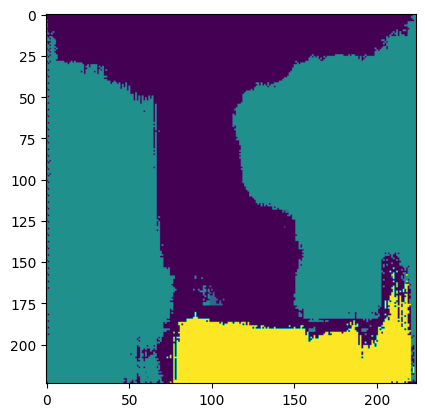

Actual mask


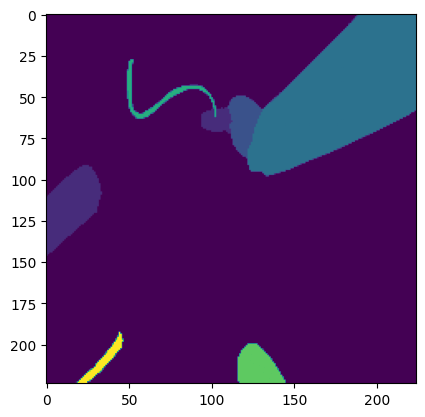

In [ ]:
first_batch = next(iter(train_loader))
one_img = first_batch[0][0]
one_label = first_batch[1][0]

output = model(one_img.unsqueeze(0))
predicted_mask = torch.argmax(output, dim=1)
print("Predicted mask")
plt.imshow(predicted_mask.squeeze(0))
plt.show()
print("Actual mask")
plt.imshow(one_label.squeeze(0))
plt.show()

Testing phase

In [ ]:
test_result = {"Loss":[], "Pixel Accuracy":[], "Mean IoU":[], "F1 Score":[]}

class_weights = torch.cat((torch.tensor([0.1]), torch.ones(9)))
criterion = nn.CrossEntropyLoss(weight=class_weights)
model = My_SemanticSegmentation(backbone, num_classes=10)
model.load_state_dict(torch.load('/content/drive/MyDrive/Colab Notebooks/SemanticSegmentation_Weights.pth', weights_only=True))
model.eval()
loss = 0
pa = 0
miou = 0
f1 = 0

with torch.no_grad():
  for img, true_mask in test_loader:
    output = model(img)
    true_mask = true_mask.squeeze(1).long()
    loss = criterion(output, true_mask)

    loss += loss.item()
    pa += pixel_accuracy(output, true_mask)
    miou += mIoU(output, true_mask, num_classes=10)
    f1 += f1_score(output, true_mask, num_classes=10)

  loss = loss / len(test_loader)
  pa = pa / len(test_loader)
  miou = miou / len(test_loader)
  f1 = f1 / len(test_loader)
  print(f"Test Loss {loss:.4f}, Pixel Accuracy:{pa:.4f}, Mean IoU:{miou:.4f}, F1 Score:{f1:.4f}")

  test_result['Loss'].append(loss.item())
  test_result['Pixel Accuracy'].append(pa)
  test_result['Mean IoU'].append(miou)
  test_result['F1 Score'].append(f1)

results = pd.DataFrame(test_result)
results.to_csv('/content/drive/MyDrive/Colab Notebooks/SemanticSegmentation_TestPerformance.csv')


Test Loss 0.0895, Pixel Accuracy:0.4185, Mean IoU:0.0686, F1 Score:0.1088


Predicted mask


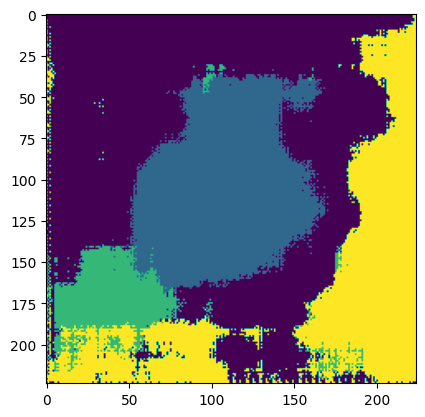

Actual mask


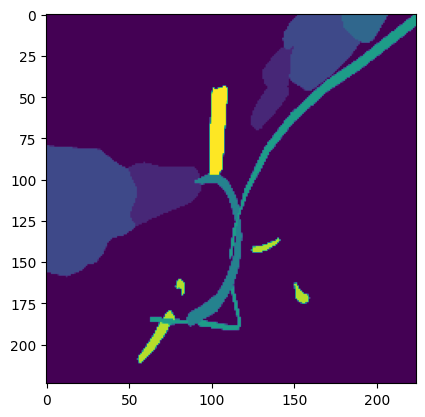

In [ ]:
first_batch = next(iter(test_loader))
one_img = first_batch[0][0]
one_label = first_batch[1][0]

output = model(one_img.unsqueeze(0))
predicted_mask = torch.argmax(output, dim=1)
print("Predicted mask")
plt.imshow(predicted_mask.squeeze(0))
plt.show()
print("Actual mask")
plt.imshow(one_label.squeeze(0))
plt.show()

## Results visualisation

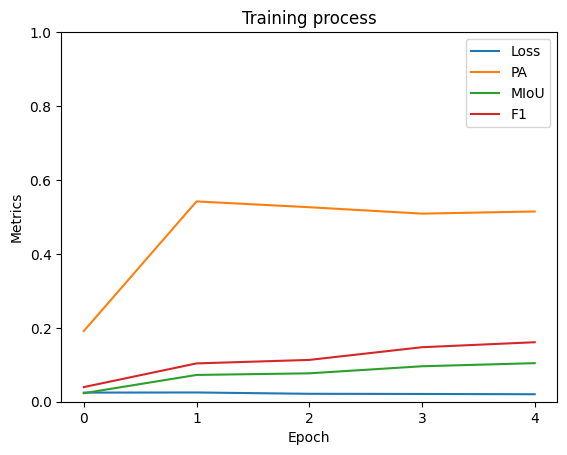

In [20]:
train_process = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/SemanticSegmentation_TrainingPerformance.csv')

plt.title("Training process")
plt.plot(train_process['Loss'], label='Loss')
plt.plot(train_process['Pixel Accuracy'], label='PA')
plt.plot(train_process['Mean IoU'], label='MIoU')
plt.plot(train_process['F1 Score'], label='F1')
plt.xlabel('Epoch')
plt.ylabel('Metrics')
plt.xticks(np.arange(0, 5, 1))
plt.ylim([0, 1])
plt.legend()
plt.show()